In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import json

In [ ]:
# Set paths
data_dir = '/content/drive/MyDrive/Coffee/Dev/C1/coffee_beans_classification/coffee_beans_data'  # Update this path
num_classes = 4
batch_size = 32
img_size = (128, 128)


# Preprocess data

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Still categorical for MobileNetV2
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 956 images belonging to 4 classes.
Found 238 images belonging to 4 classes.


# Train

In [ ]:
# Save class indices for later use
class_indices = train_generator.class_indices
with open('/content/drive/MyDrive/Coffee/Dev/C1/coffee_beans_classification/class_indices_coffee_beans.json', 'w') as f: # Update this path
    json.dump(class_indices, f)

# Load MobileNetV2 base model without top layers
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3),
    alpha=0.35
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Reduced neurons for efficiency
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32, 8) │        384 │ block_1_depthwis

 Total params: 574,692 (2.19 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 410,208 (1.56 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 542s 18s/step - accuracy: 0.3801 - loss: 1.2969 - val_accuracy: 0.6429 - val_loss: 0.9635
Epoch 2/20
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5938 - loss: 1.0108

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.5938 - loss: 1.0108 - val_accuracy: 0.6696 - val_loss: 0.9198
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.7865 - loss: 0.6984 - val_accuracy: 0.8705 - val_loss: 0.6478
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8750 - loss: 0.5312 - val_accuracy: 0.7991 - val_loss: 0.6619
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.8403 - loss: 0.5121 - val_accuracy: 0.8705 - val_loss: 0.4980
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8125 - loss: 0.4969 - val_accuracy: 0.8750 - val_loss: 0.4942
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.8708 - loss: 0.4109 - val_accuracy: 0.8839 - val_loss: 0.4153
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9062 - loss: 0.2825 - val_accuracy: 0.9062 - val_loss: 0.4081
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9011 - loss: 0.3267 - val_accuracy: 0.9196 - val_

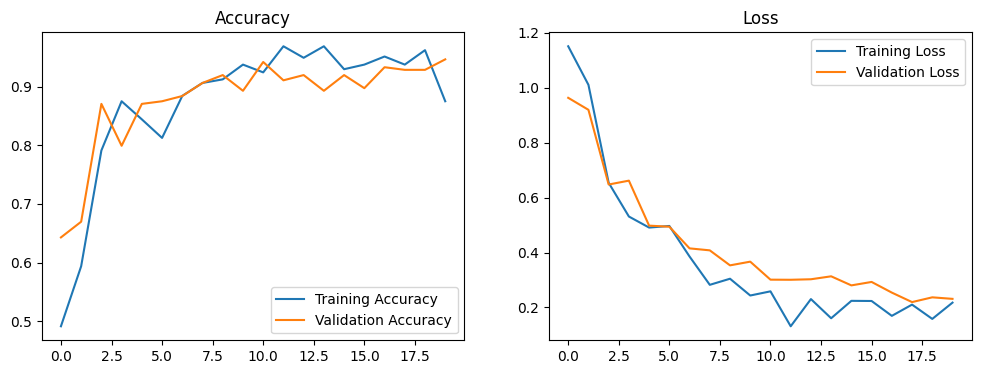

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_pd_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reduced patience for faster training
    restore_best_weights=True
)

# Calculate steps per epoch
total_train_samples = train_generator.samples
total_val_samples = validation_generator.samples

steps_per_epoch = total_train_samples // batch_size
validation_steps = total_val_samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20,  # Reduced epochs
    callbacks=[checkpoint, early_stopping]
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# FineTune

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6831 - loss: 0.9015 - val_accuracy: 0.8839 - val_loss: 0.2843
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7500 - loss: 0.5901 - val_accuracy: 0.9062 - val_loss: 0.2612
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.7231 - loss: 0.7535 - val_accuracy: 0.8705 - val_loss: 0.3363
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8438 - loss: 0.4356 - val_accuracy: 0.8705 - val_loss: 0.3151
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.7906 - loss: 0.5669 - val_accuracy: 0.8080 - val_loss: 0.4185
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7812 - loss: 0.5403 - val_accuracy: 0.8348 - val_loss: 0.4229
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.8385 - loss: 0.4074 - val_accuracy: 0.8080 - val_loss: 0.4707


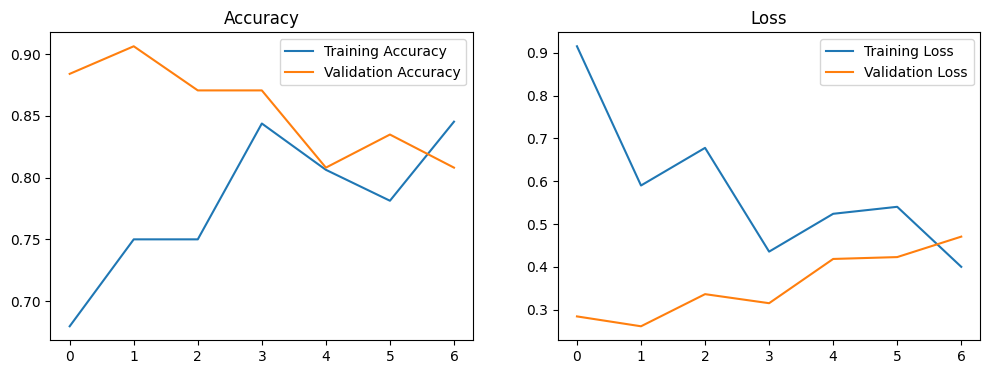

In [ ]:
# Fine-tuning: Unfreeze some layers
base_model.trainable = True
# Let's unfreeze the top 50 layers
for layer in base_model.layers[:50]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10,  # Reduced fine-tuning epochs
    callbacks=[checkpoint, early_stopping]
)

plot_history(history_fine)

# Save the final model
model.save('/content/drive/MyDrive/Coffee/Dev/C1/coffee_beans_classification/coffee_beans_classifier.keras', save_format='keras') # Update this path


# Evaluation

In [ ]:
# Load the best model for evaluation
from tensorflow.keras.models import load_model
best_model = load_model('best_pd_model.keras')

# Evaluate on validation set
val_loss, val_acc = best_model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc*100:.2f}%')


8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9415 - loss: 0.1952
Validation Accuracy: 92.86%


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 885ms/step


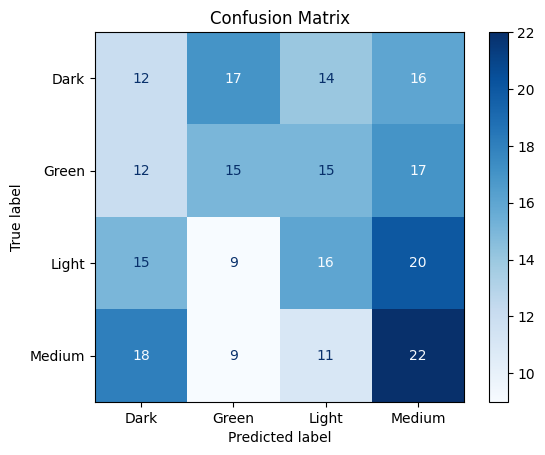

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import json # Import the json library

from tensorflow.keras.models import load_model
best_model = load_model('/content/drive/MyDrive/Coffee/Dev/C1/coffee_beans_classification/coffee_beans_classifier.keras') # Update this path
# Load class indices from the JSON file
class_indices_path = '/content/drive/MyDrive/Coffee/Dev/C1/coffee_beans_classification/class_indices_coffee_beans.json' # Update this path
with open(class_indices_path, 'r') as f:
    class_indices = json.load(f)


# Get true labels and predictions for the validation set
validation_generator.reset() # Reset the generator to ensure order
true_labels = validation_generator.classes
predictions = best_model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
class_names = list(class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Inference

In [4]:
# Load the trained Keras model
from tensorflow.keras.models import load_model
import json
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf


# Load the saved model
model_path = '/content/drive/MyDrive/Research Project/C1/coffee_beans_classification/coffee_beans_classifier.keras' # model path # Update this path
loaded_model = load_model(model_path)

# Load class indices
class_indices_path = '/content/drive/MyDrive/Research Project/C1/coffee_beans_classification/class_indices_coffee_beans.json' # class indices path # Update this path
with open(class_indices_path, 'r') as f:
    class_indices = json.load(f)

# Function to preprocess and predict on a new image
def predict_image(model, class_indices, image_path, img_size=(128, 128)):
    # Load and resize the image
    img = image.load_img(image_path, target_size=img_size)
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Expand dimensions to match model input shape (add batch dimension)
    img_array = np.expand_dims(img_array, axis=0)
    # Rescale the image (if your model was trained with rescaling)
    img_array /= 255.0

    # Make prediction
    predictions = model.predict(img_array)

    # Get the predicted class index and confidence
    predicted_class_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Map index to class name
    idx_to_class = {v: k for k, v in class_indices.items()}
    predicted_class_name = idx_to_class.get(predicted_class_index, 'Unknown')

    return predicted_class_name, confidence

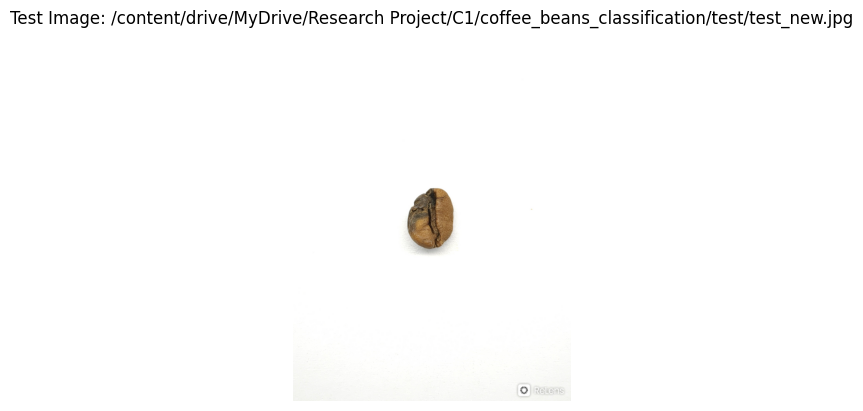

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted: Light with 44.78% confidence


In [6]:
# Update this path

test_image_path = '/content/drive/MyDrive/Research Project/C1/coffee_beans_classification/test/test_new.jpg'

import matplotlib.pyplot as plt

# Load and display the image
img = tf.keras.preprocessing.image.load_img(test_image_path)
plt.imshow(img)
plt.axis('off') # Hide axes
plt.title(f'Test Image: {test_image_path}')
plt.show()

predicted_class, confidence = predict_image(loaded_model, class_indices, test_image_path)
print(f'Predicted: {predicted_class} with {confidence*100:.2f}% confidence')